# CanOE Nitrate

Output from recent CanOE run provided by Hakase and Nadja. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
from calendar import monthrange

%matplotlib inline

Load ANHA12 coordinate file:

In [2]:
# Mesh:
mesh     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask    = np.array(mesh.variables['tmask'])[0,:,:,:]
Z_masked = np.ma.masked_where((tmask > 0.1), tmask) 
mdepth   = np.array(mesh.variables['nav_lev'])
mlons    = np.array(mesh.variables['nav_lon'])
mlats    = np.array(mesh.variables['nav_lat'])

### Functions:

In [3]:
def load_data(year, month):
    folder = '/ocean/brogalla/GEOTRACES/data/bio/Mn_202110/'
    filename = f'NO3_y{year}m{month:02}.nc'
    
    data  = nc.Dataset(folder+filename)
    NO3   = np.array(data.variables['NO3'])
    NO3   = NO3*1e-3*1e-3 # mmol/m3--> mol/L
    
    return NO3

In [4]:
def deriv(year, month):
    # Month is from 1 to 12
#     NO3_1 = load_data(year, month)
#     if month < 12:
#         NO3_2 = load_data(year, month+1)
#     else:
#         NO3_2 = load_data(year+1, 1)
        
    if (month < 4) or (month > 7): # 5 and 8
        diff = np.zeros((50,2400,1632))  # Avoid replenishment of NO3 from mixing by zeroing non-summer months
    else:
        NO3_1 = load_data(year, month)    # Current month
        NO3_2 = load_data(year, month+1)  # Next month
        nday = monthrange(year, month)[1] # Number of days in current month
        
        # Calculate difference between next month and current month, NO3_2 - NO3_1
        diff = np.subtract(NO3_2, NO3_1)/(3600*24*nday) # mol/L/month --> mol/L/s
    
    save_NO3(f'delta_prod_y{year}m{month:02}.nc', diff[:,:,:])
    return diff

In [5]:
def save_NO3(filename, field):
    ncd = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/bio/Mn_202110/{filename}', 'w', zlib=True)
    ncd.createDimension('x',1632)
    ncd.createDimension('y',2400)
    ncd.createDimension('deptht', 50)
    
    # variables
    NO3_var = ncd.createVariable('dNO3', 'float64', ('deptht','y','x'))
    NO3_var.units = 'mol/L/s'
    NO3_var.long_name = 'Month-to-month delta Nitrate'  
    NO3_var.coordinates = 'nav_lon nav_lat deptht'
    NO3_var[:] = field[:,:,:]
    
    ncd.close()
    return

In [6]:
def plot_sample(NO3, mlons=mlons, mlats=mlats):
    fig,ax = plt.subplots(figsize=(15,15))
    proj=Basemap(projection='eqdc',lat_0 = 77.5, lon_0 = -93, resolution='i', width=3.5e6, height=2.68e6)
    proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=1);

    # model:
    x, y = proj(mlons, mlats)

    # plot all together:
    CS = proj.pcolor(x, y, NO3[0,0,:,:], cmap=cmocean.cm.deep)
    CBar = plt.colorbar(CS, shrink=0.6)
    CBar.ax.tick_params(axis='y', length=0)
    CBar.set_label('Interpolated NO3', fontsize=12)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.title('ANHA12 interpolation from CanOE model output')
    return

## Run:

##### Choose year:

In [7]:
year = 2005

Calculate derivative:

Final result has to be in units of [NO_3]/s

\begin{equation*}
\frac{\partial{NO_{3}(i)}}{\partial{t}} \approxeq \frac{NO_{3}(i+1) - NO_{3}(i) }{\Delta t} = 
\frac{NO_{3}(2002m2)-NO_{3}(2002m1)}{(24*3600*ndays)} 
\end{equation*}

In [8]:
def joblib_solver(deriv, year, month):
    dNO3 = deriv(year, month) 
    return dNO3

In [9]:
months=np.arange(1,13)
joblist=[]
for month in months:
    positional_args=[deriv,year,month]
    keyword_args={}
    joblist.append((joblib_solver,positional_args,keyword_args))

In [10]:
from joblib import Parallel
ncores=1
with Parallel(n_jobs=ncores,backend='threading') as parallel:
    results=parallel(joblist)

In [8]:
i_NO3 = np.zeros((12,50,2400,1632))
for month in range(1,13):
    m = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/bio/Mn_202110/delta_prod_y2002m{month:02}.nc')
    m1 = np.array(m.variables['dNO3'])
    
    i_NO3[month-1,:,:,:] = m1

Text(0.5, 0.98, 'Change in nitrate [mol/L/s], depth level = 0')

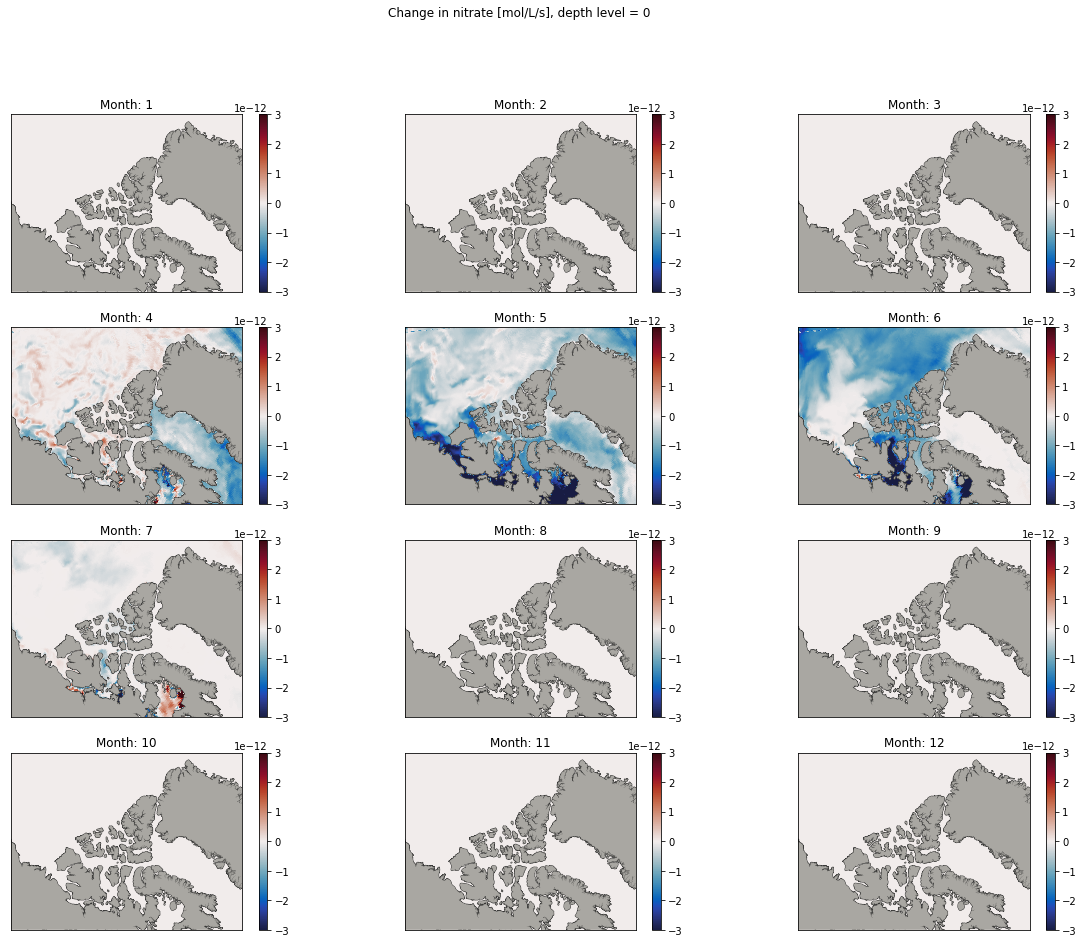

In [12]:
fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((4, 3), (0, 0)) 
ax2 = plt.subplot2grid((4, 3), (0, 1)) 
ax3 = plt.subplot2grid((4, 3), (0, 2)) 
ax4 = plt.subplot2grid((4, 3), (1, 0)) 
ax5 = plt.subplot2grid((4, 3), (1, 1)) 
ax6 = plt.subplot2grid((4, 3), (1, 2)) 
ax7 = plt.subplot2grid((4, 3), (2, 0)) 
ax8 = plt.subplot2grid((4, 3), (2, 1)) 
ax9 = plt.subplot2grid((4, 3), (2, 2)) 
ax10 = plt.subplot2grid((4, 3), (3, 0)) 
ax11 = plt.subplot2grid((4, 3), (3, 1)) 
ax12 = plt.subplot2grid((4, 3), (3, 2)) 

m=Basemap(projection='eqdc',lat_0 = 77.5, lon_0 = -93, resolution='i', width=3.5e6, height=2.68e6)
x2, y2 = m(mlons[::4,::4], mlats[::4,::4])
z2 = Z_masked[0,::4,::4]

land_color = '#a9a7a2'
for n, axis in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]):
    m.drawcoastlines(color='#373736', linewidth=1.0, ax=axis);
    m.fillcontinents(color=land_color, lake_color=land_color, zorder=2, ax=axis);
    axis.set_title(f'Month: {n+1}')
    
    d = m.pcolor(x2,y2,i_NO3[n,0,::4,::4], cmap=cmocean.cm.balance, ax=axis, vmin=-3e-12, vmax=3e-12)
     
    CBar = plt.colorbar(d, ax=axis) 
    
fig.suptitle('Change in nitrate [mol/L/s], depth level = 0',fontsize=12)

Text(0.5, 0.98, 'Change in nitrate [mol/L/s], depth level = 24')

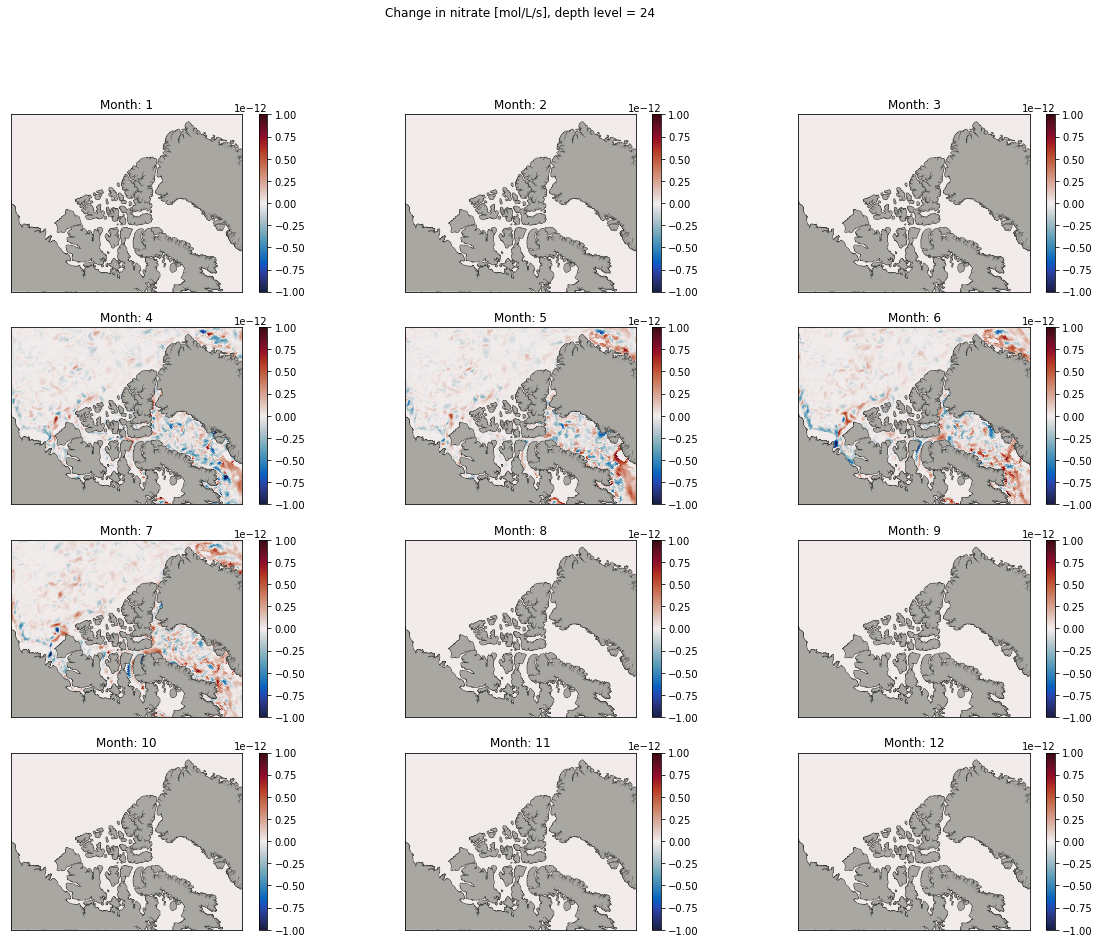

In [10]:
fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((4, 3), (0, 0)) 
ax2 = plt.subplot2grid((4, 3), (0, 1)) 
ax3 = plt.subplot2grid((4, 3), (0, 2)) 
ax4 = plt.subplot2grid((4, 3), (1, 0)) 
ax5 = plt.subplot2grid((4, 3), (1, 1)) 
ax6 = plt.subplot2grid((4, 3), (1, 2)) 
ax7 = plt.subplot2grid((4, 3), (2, 0)) 
ax8 = plt.subplot2grid((4, 3), (2, 1)) 
ax9 = plt.subplot2grid((4, 3), (2, 2)) 
ax10 = plt.subplot2grid((4, 3), (3, 0)) 
ax11 = plt.subplot2grid((4, 3), (3, 1)) 
ax12 = plt.subplot2grid((4, 3), (3, 2)) 

m=Basemap(projection='eqdc',lat_0 = 77.5, lon_0 = -93, resolution='i', width=3.5e6, height=2.68e6)
x2, y2 = m(mlons[::4,::4], mlats[::4,::4])
z2 = Z_masked[0,::4,::4]

land_color = '#a9a7a2'
for n, axis in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]):
    m.drawcoastlines(color='#373736', linewidth=1.0, ax=axis);
    m.fillcontinents(color=land_color, lake_color=land_color, zorder=2, ax=axis);
    axis.set_title(f'Month: {n+1}')
    
    d = m.pcolor(x2,y2,i_NO3[n,24,::4,::4], cmap=cmocean.cm.balance, ax=axis, vmin=-1e-12, vmax=1e-12)
     
    CBar = plt.colorbar(d, ax=axis) 
    
fig.suptitle('Change in nitrate [mol/L/s], depth level = 24',fontsize=12)